# Ab-initio synthesis of amino acids

The Urey-Miller experiment, demonstrated for the first time, the prebiotic synthesis of amino acids. Although this result has been reproduced multiple times experimentally, there have been very few in-silico attempts of the same.  

Our study explores the role of standard Gibbs free energy change as a key parameter in the in-silico synthesis of Glycine in a Miller-like experiment. A network theoretic approach is used to model the experiment and simulated annealing is used to scan the reaction space.  

This file contains the following functions:
- `get_number_bonds`
- `get_neutral_compound`
- `generate_random_graphs`
- `rearrange_connected_components`
- `simulated_annealing`
- `plot_fig`
- `fix_valencies`
- `input_G`

The fucntion `form_bonds` and the code for Strecker's amino acid synthesis is available in `main2.ipynb`

In [1]:
# Import all essential libraries

import os
import csv
import math
import warnings
import random
import numpy as np
import networkx as nx
import scipy.constants as sc
import matplotlib.pyplot as plt
import networkx.algorithms.isomorphism as iso
from IPython.core.debugger import Pdb
ipdb = Pdb()

The `plot_fig` function is used for plotting the network. The following color code has been used in the network:
   - Grey: Carbon
   - Green: Hydrogen
   - Blue: Nitrogen
   - Red: Oxygen  
   
Input: Graph  to be plotted

In [2]:
def plot_fig(G, title=""):
    A = nx.adjacency_matrix(G)
    pos = nx.spring_layout(G)
    nodes = list(nx.nodes(G))
    mapping = {}
    for i,j in enumerate(nodes):
        mapping[j] = i
        
    plt.figure()
    if title: plt.title(title)
    for i in G.edges():
        G[i[0]][i[1]][0]['number'] = A[mapping[i[0]], mapping[i[1]]]
    labels = nx.get_edge_attributes(G, 'number')
    edge_labels = {}
    node_colors = []
    for i in nx.nodes(G):
        if i._element=="H":
            node_colors.append('#ccffd3')
        elif i._element=="C":
            node_colors.append('grey')
        elif i._element=="O":
            node_colors.append('red')
        elif i._element=="N":
            node_colors.append('#74b6fc')
            
            
    for i in labels:
        edge_labels[(i[0], i[1])] = labels[i]
    nx.draw(G, pos, with_labels=True,edge_color='black',width=1,linewidths=1,node_size = 500,node_color=node_colors,alpha=0.9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
    plt.show()

Definition of the Atom class. The objects of this Class are used as nodes in our network.
Attributes in the Class:
  - `_number`: number tag
  - `_element`: element
  - `_valency`: valency
  - `_name`: element + number tag  
  
Member functions in the Class:
  - `get_max_valency`: returns the maximum valency of that element
  - `current_valency`: updates the valency of an Atom object. Takes a Graph as an input
  - `get_free_valency`: returns the number of free electrons of a node. Takes a graph as an input

In [3]:
class Atom():
    def __init__(self, name, number):
        self._name = name + " " + str(number)
        self._number = number
        self._element = name
        self._valency = self.get_max_valency()

    def get_max_valency(self):
        name = self._element[0]
        if name == "H":
            return 1
        elif name == "C":
            return 4
        elif name == "N":
            return 3
        elif name == "O":
            return 2
        elif name == "S":
            return 2

    def current_valency(self, G):
        neig = nx.degree(G, self)
        max_val = self.get_max_valency()
        if neig > max_val:
            ipdb.set_trace()
            raise ValueError('Atom has more neighbours than valence')
        else:
            # print(max_val, neig)
            self._valency = max_val - neig
        
    def get_free_valency(self, G):
        neig = nx.degree(G, self)
        free_electrons = self.get_max_valency() - neig
        return free_electrons
        
        
    def __repr__(self):
        return self._name

In [4]:
# Defining the list of atoms to be added to the graph

H_list = [Atom("H", i) for i in range(1,33)]
C_list = [Atom("C", i) for i in range(33, 41)]
O_list = [Atom("O", i) for i in range(41, 49)]
N_list = [Atom("N", i) for i in range(49, 57)]

complete_list = [];
for lst in [H_list, C_list, O_list, N_list]:
    complete_list.extend(lst)

Creating the graph with just atoms. MultiGraph is being used for ease of representing double and possible triple bonds. Here, 
- `lst` loops through the lists (H, C, O and N)
- `comp` loops over the compounds

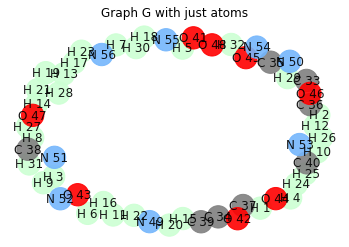

In [5]:
G = nx.MultiGraph()
for i,lst in enumerate([H_list, C_list, O_list, N_list]):
    for comp in lst:
        G.add_node(comp, data=comp)
plot_fig(G, "Graph G with just atoms")

---
The `fix_valencies` function is used to update the valencies of the atoms. This updates the atom's valency based on the number of edges that atom forms.  
Input:
- `G`: Network in which the valencies should be updated

In [6]:
def fix_valencies(G):
    for node in nx.nodes(G):
        degree = len(G[node])
        if degree > 0:
            node.current_valency(G)

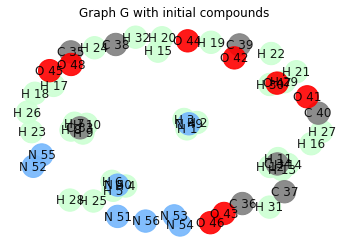

In [7]:
# Adding all the initial compounds to the network

G.add_edges_from([(H_list[0], N_list[0]), (N_list[0], H_list[1]), (N_list[0], H_list[2])])
G.add_edges_from([(H_list[3], N_list[1]), (N_list[1], H_list[4]), (N_list[1], H_list[5])])

G.add_edges_from([(H_list[6], C_list[0]), (H_list[7], C_list[0]), (H_list[8], C_list[0]), (H_list[9], C_list[0])])
G.add_edges_from([(H_list[10], C_list[1]), (H_list[11], C_list[1]), (H_list[12], C_list[1]), (H_list[13], C_list[1])])

G.add_edges_from([(O_list[6], H_list[28]), (O_list[6], H_list[29])])

fix_valencies(G)
plot_fig(G, "Graph G with initial compounds")

In [8]:
# Get the list of all components and atoms in the network

atoms = []
compounds = []
all_compounds = nx.connected_components(G)
list_compounds = list(all_compounds)

for i in range(len(list_compounds)):
    if len(list(list_compounds[i])) == 1:
        atoms.append(list(list_compounds[i])[0])
    else:
        compounds.append(list(list_compounds[i]))

In [9]:
# Get the distribution of free electrons in the network

free_electrons = []
for i in complete_list:
    val = 0
    compound_contrib = {}
    if np.size(i) > 1:
        for j in i:
            compound_contrib[j] = j.get_free_valency(G)
            val += j.get_free_valency(G)
    else:
        compound_contrib[i] = i.get_free_valency(G)
        val += i.get_free_valency(G)
    free_electrons.append((val, compound_contrib))

In [10]:
# Get the maximum number of edges that can be formed

maximum_edges = 0; 
for lst in [H_list, C_list, O_list, N_list]:
    for atom in lst:
        maximum_edges += atom.get_max_valency()
        
maximum_edges = maximum_edges//2;
print("The maximum number of edges in G graph:", maximum_edges)

The maximum number of edges in G graph: 52


---  

Creating the `H` graph to be used for `input_G` isomorphism
The `data_G` dictionary links these components to their corresponding free energy values

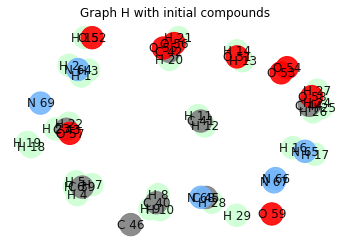

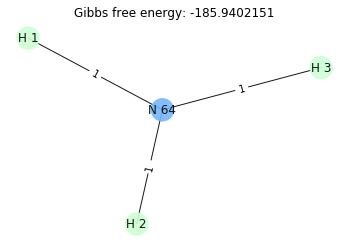

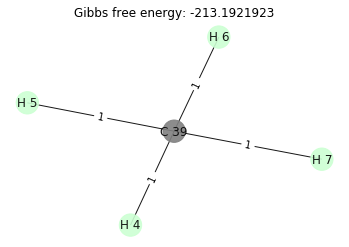

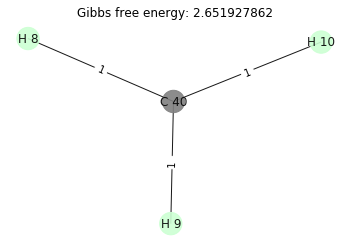

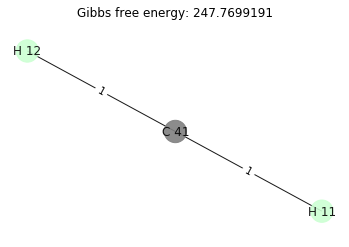

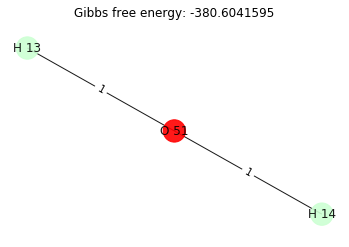

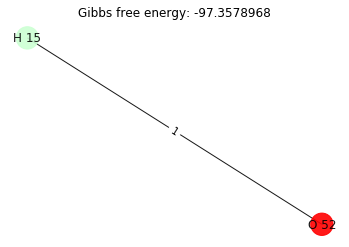

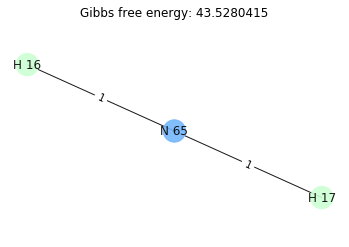

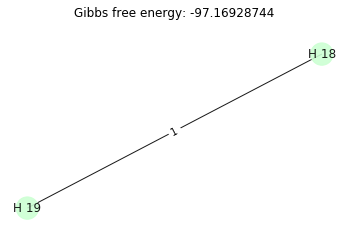

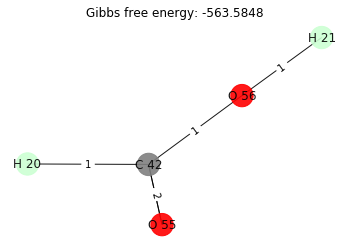

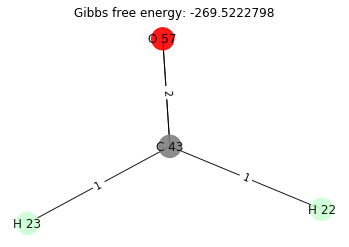

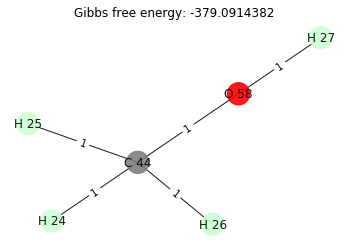

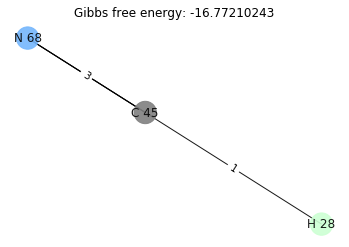

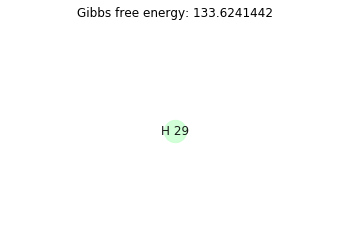

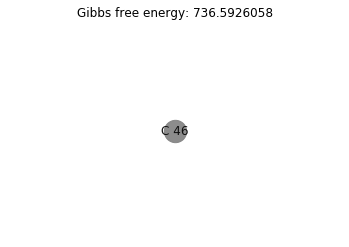

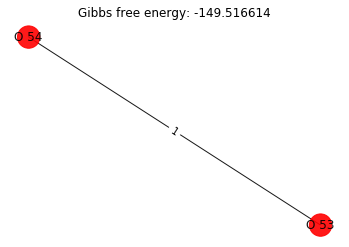

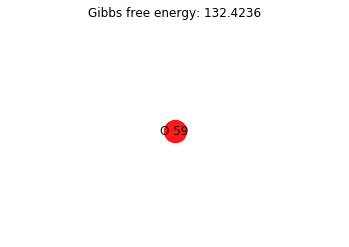

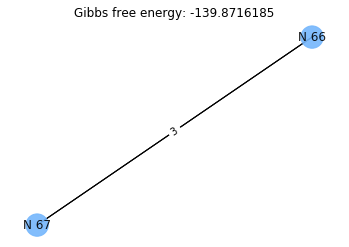

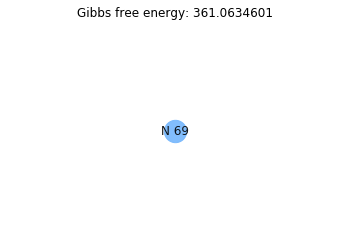

In [11]:
H = nx.MultiGraph()

H_lists = [Atom("H",i) for i in range(1,30)]
C_lists = [Atom("C",i) for i in range(39, 47)]
O_lists = [Atom("O",i) for i in range(51, 60)]
N_lists = [Atom("N",i) for i in range(64, 70)]
for i,lst in enumerate([H_lists, C_lists, O_lists, N_lists]):
    for comp in lst:
        H.add_node(comp, data=comp)

H.add_edges_from([(H_lists[0], N_lists[0]), (N_lists[0], H_lists[1]), (N_lists[0], H_lists[2])])
H.add_edges_from([(H_lists[3], C_lists[0]), (H_lists[4], C_lists[0]), (H_lists[5], C_lists[0]), (H_lists[6], C_lists[0])])
H.add_edges_from([(H_lists[7], C_lists[1]), (H_lists[8], C_lists[1]), (H_lists[9], C_lists[1])])
H.add_edges_from([(H_lists[10], C_lists[2]), (H_lists[11], C_lists[2])])
H.add_edges_from([(H_lists[12], O_lists[0]), (H_lists[13], O_lists[0])])
H.add_edges_from([(H_lists[14], O_lists[1])])
H.add_edges_from([(H_lists[15], N_lists[1]), (N_lists[1], H_lists[16])])
H.add_edges_from([(H_lists[17], H_lists[18])])
H.add_edges_from([(O_lists[2], O_lists[3])])
H.add_edges_from([(N_lists[2], N_lists[3]), (N_lists[2], N_lists[3]), (N_lists[2], N_lists[3])])
H.add_edges_from([(H_lists[19], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[5], C_lists[3]),(H_lists[20], O_lists[5])])
H.add_edges_from([(H_lists[21], C_lists[4]),(O_lists[6], C_lists[4]),(O_lists[6], C_lists[4]),(H_lists[22], C_lists[4])])
H.add_edges_from([(H_lists[23], C_lists[5]), (H_lists[24], C_lists[5]), (H_lists[25], C_lists[5]),(O_lists[7], C_lists[5]),(O_lists[7], H_lists[26])])
H.add_edges_from([(H_lists[27], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6])])

plot_fig(H, "Graph H with initial compounds")

data_G = {}
G_value = [-185.9402151,-213.1921923,2.651927862,247.7699191,-380.6041595,-97.3578968,43.5280415,-97.16928744,-563.5848,-269.5222798,-379.0914382,-16.77210243,133.6241442,736.5926058,-149.516614,132.4236,-139.8716185,361.0634601]

entities = nx.connected_components(H)
entities = list(entities)
for i in range(len(entities)):
    sub = H.subgraph(list(entities[i]))
    data_G[sub] = G_value[i]
    plot_fig(sub, "Gibbs free energy: " + str(G_value[i]))
fix_valencies(H)    

In [12]:
fix_valencies(G)

Finding $\Delta G^{\circ}$ of all the connected components in a network
Input: 
- G: the Graph network for which G should be calculated
Output: 
- Sum total Gibbs free energy for the whole Graph

In [13]:
def input_G(G):
    cc = list(nx.connected_components(G))
    G_energy = 0
    
    for i in range(len(cc)):
        found = 0
        
        sub_G = G.subgraph(list(cc[i]))
        same = False
        
        for j in data_G:
            GH = iso.GraphMatcher(sub_G,j)
            
            if GH.is_isomorphic() == True:
                same = True
            else:
                same = False
            
            if same == True:
                if len(GH.mapping) != 2:
                    for k in GH.mapping: # check mapping of each nodes
                        if str(k)[0] == str(GH.mapping[k])[0]: # Each node's label (without index) should coincide
                            same = True
                        else:
                            same = False
                            break
                else:
                    keys = []
                    values = []
                    for i in GH.mapping.keys():
                        keys.append(str(i).split()[0])
                    for i in GH.mapping.keys():
                        values.append(str(i).split()[0])
                    keys = keys.sort()
                    values = values.sort()
                    if keys == values:
                        same = True
                    else: 
                        same = False
                
            if same == True: # If compound is found, add G
                found = 1
                break

        if same == True:
            G_energy += data_G[j]
            
        elif same == False: # If compound not found,
            randomp = G.subgraph(list(cc[i]))
            plot_fig(randomp)
            
            val = float(input('Enter G value of %s: '%list(cc[i])))
            data_G[sub_G] = val # Add the new compound's data to our dictionary
            G_energy += val
    return G_energy

---
So as to allow for gradual addition of bonds in the network, we generated a bond distribution that imitates a Michaelis-Menten like curve for the number of bonds allowable at a given cycle and the `ceil` the value is used.

In [14]:
def get_number_bonds(s, max_bonds):
    bond = math.ceil((max_bonds*s)/(0.5 + s))
    
    return bond

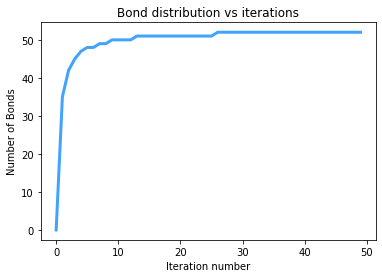

In [15]:
# Demonstration of get_number_bonds over 50 iterations

max_bonds = 52
x_val = list(range(0,50))
y_val = [get_number_bonds(i, max_bonds) for i in x_val]

plt.figure()
plt.xlabel("Iteration number",fontsize = 10)
plt.ylabel('Number of Bonds',fontsize = 10)
plt.title('Bond distribution vs iterations' , fontsize = 12)
plt.plot(x_val,y_val, linewidth=3,  color = '#40a3ff', markeredgewidth=3, markerfacecolor='black');

This function produces electrically neutral subgraphs in the following manner:
- All connected components of size 2 and above are selected
- Atoms in the connected component that have un-satisfied valency are identified and the valencies of the neighboring atoms are scanned. Atoms that had neighboring atoms with unsatisfied valency, are allowed to form multiple bonds with the neighboring atoms until the valency of the atom or its neighbor is satisfied.
- If the valency of the atom is still not satisfied, then free hydrogens in the network were added to the atom with a valency deficiency. In order to take all cases into consideration, hydrogen atoms were added to the network when needed.
  
Input:
   - `G`: A network comprising of non-electrically neutral compounds
Output:
   - `G_new`: Updated `G` graph with electrically neutral subgraphs

In [16]:
def get_neutral_compound(G):
    G_new = G.copy()
    connected_components = list(nx.connected_components(G_new))
    fix_valencies(G_new)
    single_nodes = [list(i) for i in connected_components if len(i) == 1]
    
    for cc in connected_components:
        if len(cc) > 1:
            M = G_new.subgraph(list(cc))
            nodes = list(nx.nodes(M))
            for node in nodes:
                neigh_sum = 0
                if node._valency != 0:
                    neigh_valencies = [(i._valency, i) for i in nx.neighbors(G_new,node)]
                    for i in neigh_valencies: 
                        neigh_sum += i[0]
                        
                    if len(neigh_valencies)>0:
                        possible_neigh = [(i,x[0],x[1]) for i,x in enumerate(neigh_valencies) if x[0]>0]
                        if len(possible_neigh) > 1:
                            pos = random.randint(0, len(possible_neigh)-1)
                            for i in range(min(node._valency, possible_neigh[pos][1])):
                                G_new.add_edge(node, possible_neigh[pos][2])
                            fix_valencies(G_new)
                        elif len(possible_neigh)==1:
                            pos = 0
                            for i in range(min(node._valency, possible_neigh[pos][1])):
                                G_new.add_edge(node, possible_neigh[pos][2])
                            fix_valencies(G_new)
                            
                    if node._valency != 0:
                        noof_H = 0
                        H_nodes = []
                        for i in single_nodes:
                            if i[0]._element == "H":
                                H_nodes.append(i[0])
                                noof_H += 1
                        if node._valency <= noof_H:
                            for i in range(node._valency):
                                G_new.add_edge(node, H_nodes[i])
                        else:
                            N = len(nx.nodes(G_new))+1
                            for i in range(node._valency):
                                new_node = Atom("H", i+N)
                                G_new.add_node(new_node)
                                G_new.add_edge(node, new_node)
                    
                    single_nodes = [list(i) for i in nx.connected_components(G_new) if len(i)==1]
            
                fix_valencies(G_new)
    return G_new

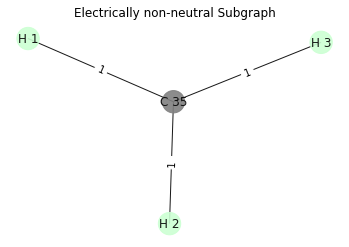

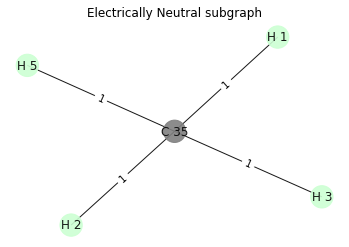

In [17]:
# Demonstration of get_neutral_compound

c35 = Atom("C", 35)
h1 = Atom("H", 1)
h2 = Atom("H", 2)
h3 = Atom("H", 3)

test = nx.MultiGraph()
test.add_node(c35)
test.add_node(h1)
test.add_node(h2)
test.add_node(h3)

test.add_edges_from([(c35,h1), (c35,h2), (c35,h3)])
plot_fig(test, "Electrically non-neutral Subgraph")
fix_valencies(test)
test = get_neutral_compound(test)
plot_fig(test, "Electrically Neutral subgraph")

The random graph generator algorithm does the following:
- A random node is initially picked from all the nodes in the network.
- All nodes which have their valency satisfied were rejected and more nodes were sampled.
- Once a node with unsatisfied valency is picked, a second node is selected from the network, which also has an unsatisfied valency.
- After the two nodes are selected, a random integer, max_num_edge, ranging from 1 to the minimum of the unsatisfied valencies of the two nodes is picked.
- Between the two nodes picked, max_num_edge bonds are added.

Input:
- `G`: Initial network on which the random graph generator algorithm works
- `max_bonds`:Maximum number of bonds possible in the network
- `iteration`: Iteration number that is passed to the get_number_bonds function
- `max_size`: The maximum size of the compound that can be formed

Output:
   - `G_fixed`: Final network with randomly generated compounds

**Note**: Compounds of maximum 2*`max_size` could be formed

In [18]:
def generate_random_graphs(G, max_bonds, iteration, max_size):
    G_new = G.copy()
    nodes = []
    for i in nx.connected_components(G_new):
        if len(i) < max_size:
            nodes.extend(list(i))
    
    valency_incomplete_nodes = [i for i in nx.nodes(G_new) if i._valency!=0]
    connected_components = nx.connected_components(G_new)
    num_executed = 0
    
    bonds = get_number_bonds(iteration, max_bonds)
    if bonds > max_bonds:
        bonds = 0

    while (nx.number_of_edges(G_new) < bonds) and (len(nodes)>1) and (len(valency_incomplete_nodes) > 1):
        print(bonds - nx.number_of_edges(G_new), "bonds to be formed.")
        num_executed += 1
        flag = 0
        initial_net = G_new
        row = random.randint(0,len(nodes)-1)
        cur_val1 = (nodes[row])._valency
        
        while not(cur_val1 >= 1):
            flag = 1
            row = random.randint(0,len(nodes)-1)
            cur_val1 = nodes[row]._valency
        else:
            col = random.randint(0, len(nodes)-1)
            cur_val2 = nodes[col]._valency
            while (cur_val2 < 1) or (row==col):
                flag = 2
                col = random.randint(0, len(nodes)-1)
                cur_val2 = nodes[col]._valency
                if cur_val2 > 0 and (row!=col):
                    max_num_edges = random.randint(1, min(nodes[row]._valency, nodes[col]._valency))
                    for times in range(max_num_edges):
                        G_new.add_edge(nodes[row], nodes[col])
            
            # Pruning any self edges
            for i in range(len(nodes)):
                neigh = G_new[nodes[i]]
                while nodes[i] in neigh:
                    G_new.remove_edge(nodes[i], nodes[i])
                
            # print("flag_end:", flag)
            if flag == 0 and (row!= col):
                if min(nodes[row]._valency, nodes[col]._valency) > 1:
                    max_num_edges = random.randint(1, min(nodes[row]._valency, nodes[col]._valency))
                else: max_num_edges = 1
                for times in range(max_num_edges):
                    G_new.add_edge(nodes[row], nodes[col])
        
        plot_fig(G_new)
        for i in list(nx.nodes(G_new)):
            try:
                # print(i._name, i._valency)
                i.current_valency(G_new)
                # print(i._name, i._valency)
            except ValueError:
                print("ValueException occured !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                ipdb.set_trace()
                for cc in nx.connected_components(G_new):
                    if nodes[row] in cc:
                        plot_fig(G_new.subgraph(list(cc)))
                
        nodes = []
        for i in nx.connected_components(G_new):
            if len(i) < max_size:
                nodes.extend(list(i))
    print("Getting the electrically neutral subgraph ...")
    G_fixed = get_neutral_compound(G_new)
    plot_fig(G_fixed)
    
    return G_fixed

12 bonds to be formed.


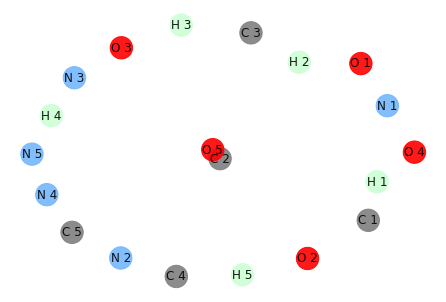

11 bonds to be formed.


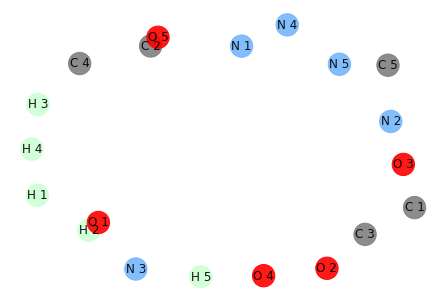

10 bonds to be formed.


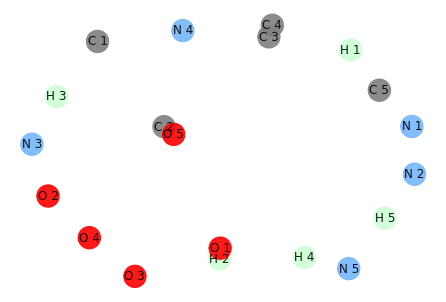

9 bonds to be formed.


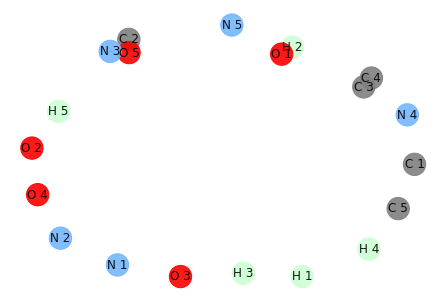

8 bonds to be formed.


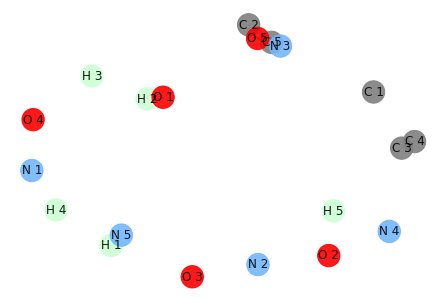

7 bonds to be formed.


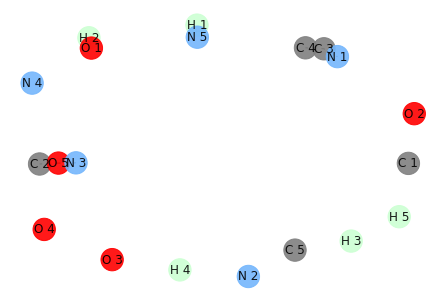

6 bonds to be formed.


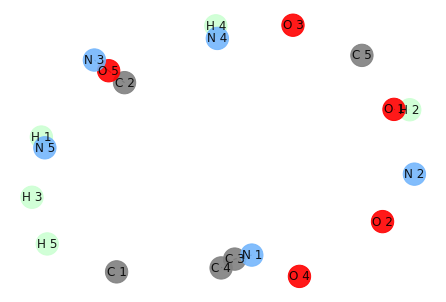

5 bonds to be formed.


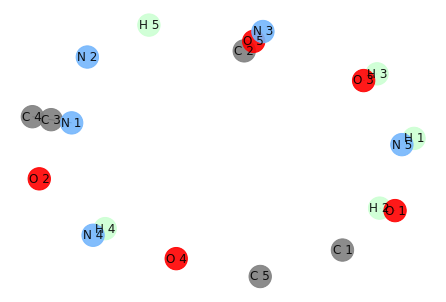

4 bonds to be formed.


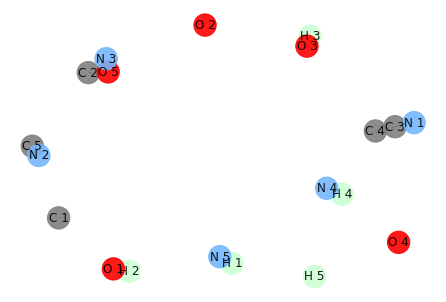

3 bonds to be formed.


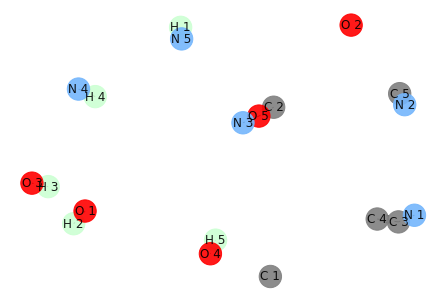

2 bonds to be formed.


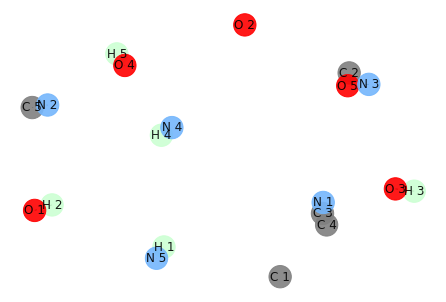

2 bonds to be formed.


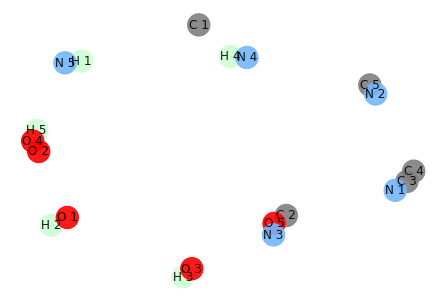

1 bonds to be formed.


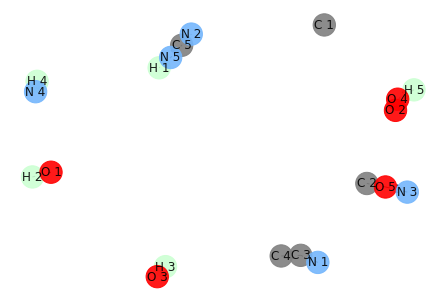

Getting the electrically neutral subgraph ...


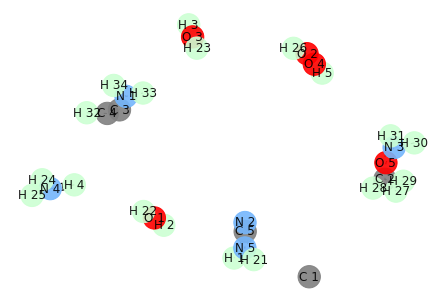

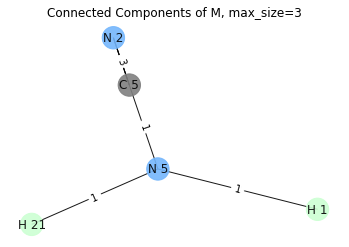

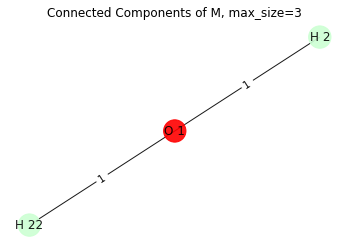

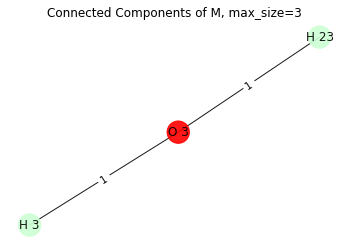

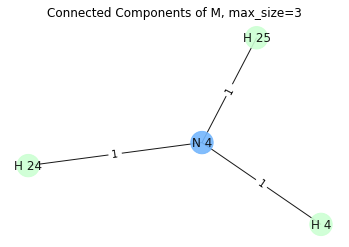

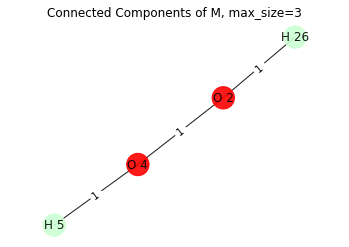

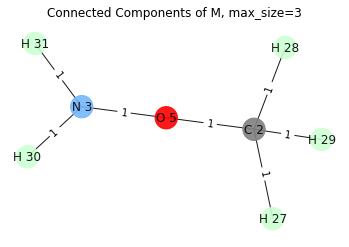

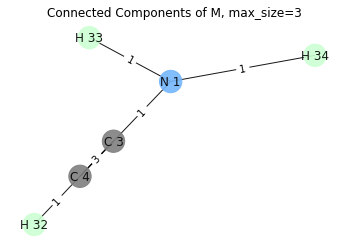

Getting the electrically neutral subgraph ...


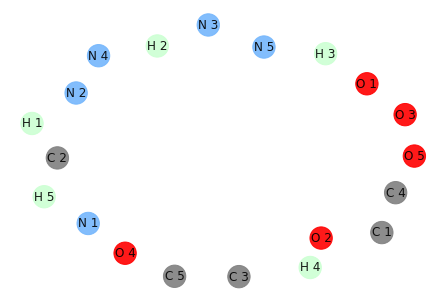

In [19]:
# Demonstration of generate_random_graphs

A_list = [Atom("H", i) for i in range(1,6)]
B_list = [Atom("C", i) for i in range(1,6)]
Z_list = [Atom("O", i) for i in range(1,6)]
Y_list = [Atom("N", i) for i in range(1,6)]

%matplotlib inline
M = nx.MultiGraph()
for i,lst in enumerate([A_list, B_list, Z_list, Y_list]):
    for comp in lst:
        M.add_node(comp, data=comp)

fix_valencies(M)

new_M2 = generate_random_graphs(M, 15, 2, 3)
for i in nx.connected_components(new_M2):
    if len(i) > 1:
        plot_fig(new_M2.subgraph(list(i)), "Connected Components of M, max_size=3")
        
new_M3 = generate_random_graphs(M, 15, 2, 2)
for i in nx.connected_components(new_M3):
    if len(i) > 1:
        plot_fig(new_M3.subgraph(list(i)), "Connected Components of M, max_size=2")

---
The `rearrange_connected_components` function does the following:
- Two nodes from two different connected components that have the same number of edges to another node are picked. - The two connected components are split and the compounds are crossed over. The number of crossovers in the graph are largely determined by `p` from Simulated Annealing.

Input: 
- `G`: The network on which rearrangement should be performed
- `cc`: List of connected components in the network
- `times`: Number of times reshuffling should be performed

In [20]:
def rearrange_connected_components(G, cc, times):
    n = len(cc)
    for i in range(times):
        comp1_idx = random.randint(0,n-1)
        comp2_idx = random.randint(0,n-1)
        comp1 = G.subgraph(list(cc[comp1_idx]))
        comp2 = G.subgraph(list(cc[comp2_idx]))
        
        plot_fig(comp1, "Connected component 1")
        plot_fig(comp2, "Connected component 2")
        attr1 = nx.get_edge_attributes(comp1, 'number')
        attr2 = nx.get_edge_attributes(comp2, 'number')
        num_rewire = 0
        
        if len(attr1) > 0 and len(attr2) > 0:
            rewire_flag = False
            attempt = 0
            # Allowing it 3 attempts max, in case it didn't rewire
            while (rewire_flag == False) and (attempt < 3):
                edge1_idx = random.randint(0,len(attr1)-1)
                edge1_valence = list(attr1.values())[edge1_idx]
                edge1_nodes = list(attr1.keys())[edge1_idx]

                possible_edge2_nodes = [i for i in attr2 if attr2[i]==edge1_valence]
                if len(possible_edge2_nodes) >= 1: 
                    r = random.randint(0, len(possible_edge2_nodes)-1)
                    edge2_nodes = possible_edge2_nodes[r]
                    
                    G.remove_edge(edge1_nodes[0], edge1_nodes[1])
                    G.remove_edge(edge2_nodes[0], edge2_nodes[1])
                    num_rewire += 1
                    rewire_flag = True
                    attempt += 1
                    for number in range(edge1_valence):
                        G.add_edge(edge1_nodes[0], edge2_nodes[0])
                        G.add_edge(edge1_nodes[1], edge2_nodes[1])
        
        if len(attr1) > 0 and len(attr2) == 0:
            max_valency = list(cc[comp2_idx])[0]._valency
            possible_edge1_nodes = [i for i in attr1 if attr1[i]<=max_valency]
            if len(possible_edge1_nodes) >= 1:
                r = random.randint(0, len(possible_edge1_nodes)-1)
                edge1_nodes = possible_edge1_nodes[r]
                valency = attr1[edge1_nodes]

                G.remove_edge(edge1_nodes[0], edge1_nodes[1])
                num_rewire += 1
                for number in range(valency):
                    G.add_edge(edge1_nodes[0], list(cc[comp2_idx])[0])

        if len(attr2) > 0 and len(attr1) == 0:
            max_valency = list(cc[comp1_idx])[0]._valency
            possible_edge2_nodes = [i for i in attr2 if attr2[i]<=max_valency]
            if len(possible_edge2_nodes) >= 1: 
                r = random.randint(0, len(possible_edge2_nodes)-1)
                edge2_nodes = possible_edge2_nodes[r]
                valency = attr2[edge2_nodes]

                G.remove_edge(edge2_nodes[0], edge2_nodes[1])
                num_rewire += 1
                for number in range(valency):
                    G.add_edge(edge2_nodes[0], list(cc[comp1_idx])[0])
                    
        fix_valencies(G)
        
    return G

The `simulated_annealing` function does the following:
- The sum total of the Gibbs free energy change of compounds in the network is used as the measure of “goodness” of a solution state. 
- As the iteration increases, the probability of accepting a bad solution is decreased. This probability is governed by the following equations:  
    $$
    {p = \exp\Bigl({\frac{-(\Delta G^{\circ}_{tot, current} - \Delta G^{\circ}_{tot, best})}{T}}\Bigr)} \\   
    $$
    
    $$
    {T = (0.995)^{iteration}T_{intial}}
    $$
  
Where, $\Delta G^{\circ}_{tot}$ represents the total standard free energy change, $T$ represents the temperature and $T_{intial}$ represents the initial temperature.

In order to sample the solution space, the rearrange connected component function was used. A random variable (`p`), distributed uniformly between $[0,1]$, was picked and the outcome of the random distribution was used to determine the intensity of connected component rearrangement. Based on the value of `p`, the extent of reshuffling was determined in the following manner:
- ${p < 0.1}$: All the connected components are completely reshuffled
- ${0.1 < p < 0.6}$: Four connected components are selected, two reshufflings are performed
- ${0.6 < p < 0.8}$: Two connected components are selected, one reshuffling is performed
- ${p > 0.8}$: No reshuffling is performed
\end{itemize}

In [21]:
# Simulated Annealing

def simulated_annealing(best_G, max_bonds, least_energy, bond_factor, T, max_size):
    p = random.uniform(0.0, 1.0)
    cc = list(nx.connected_components(G))
    n = len(cc)
    if p < 0.1:
        times = n//2        
        G_rand = generate_random_graphs(G, max_bonds, bond_factor, max_size)
        G_new = rearrange_connected_components(G_rand, cc, times)
        G_new = get_neutral_compound(G_new)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
    
    elif p < 0.6:
        times = min(n//2, 2)
        G_rand = generate_random_graphs(G, max_bonds, bond_factor, max_size)
        G_new = rearrange_connected_components(G_rand, cc, times)
        G_new = get_neutral_compound(G_new)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
    
    else:
        times = min(n//2, 1)
        G_rand = generate_random_graphs(G, max_bonds, bond_factor, max_size)
        G_new = rearrange_connected_components(G_rand, cc, times)
        G_new = get_neutral_compound(G_new)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
        
    if new_energy < least_energy and new_energy < rand_energy:
        best_G = G_new
        least_energy = new_energy
    elif rand_energy < new_energy and rand_energy < least_energy:
        best_G = G_rand
        least_energy = rand_energy
    else:
        p_decide = random.uniform(0.0,1.0)
        try:
            accept_new = math.exp(-(new_energy-least_energy)/T)
        except:
            if (new_energy-least_energy) > 0:
                accept_new = 0
            else:
                accept_new = float('inf')
        try:
            accept_rand = math.exp(-(rand_energy-least_energy)/T)
        except:
            if (rand_energy-least_energy) > 0:
                accept_rand = 0
            else:
                accept_rand = float('inf')

        if p_decide < accept_new:
            best_G = G_new
            least_energy = new_energy
        elif p_decide < accept_rand:
            best_G = G_rand
            least_energy = rand_energy
    
    return (best_G, least_energy)   

The thermodynamic data gathered so far is available [here](https://bit.ly/2BSSLqr).  

In case the compound is not available in the database, the structure can be searched [here](https://www.chemspider.com/StructureSearch.aspx).  

The compound thermodynamic data can be accessed [here](https://rmg.mit.edu/molecule_search).  

In case the thermodynamic data is in the NASA format, the Gibbs free energy can be calculated [here](https://github.com/sowmyamanojna/Computational-Systems-Biology-project/blob/master/code/calc_compound_G.ipynb).

Trail: 0
Getting the electrically neutral subgraph ...


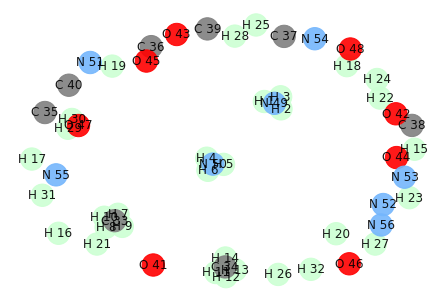

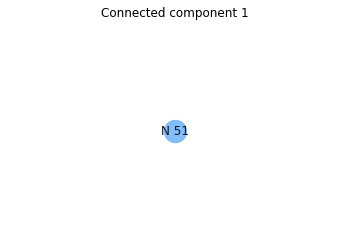

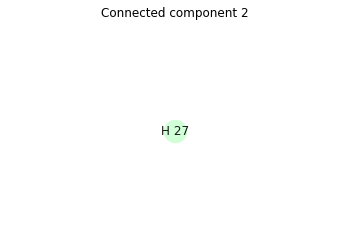

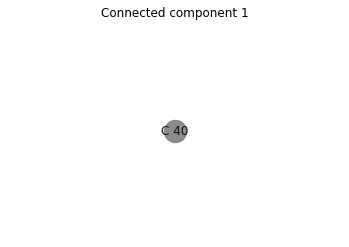

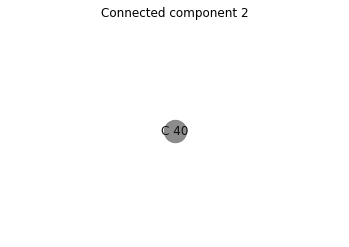

Trail: 1
19 bonds to be formed.


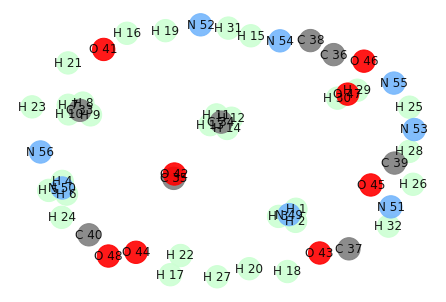

17 bonds to be formed.


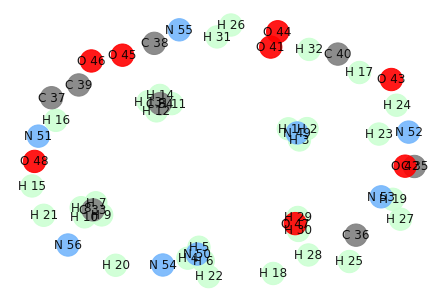

16 bonds to be formed.


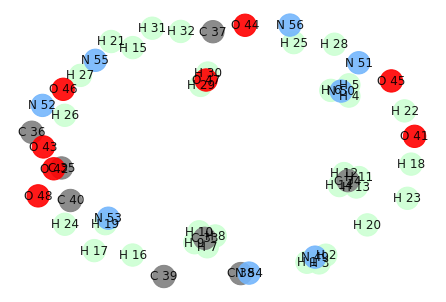

15 bonds to be formed.


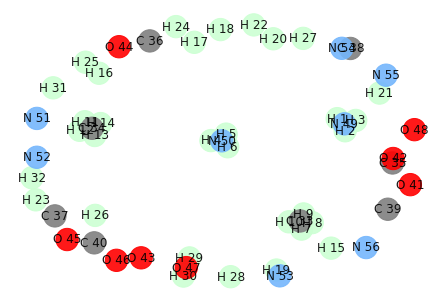

15 bonds to be formed.


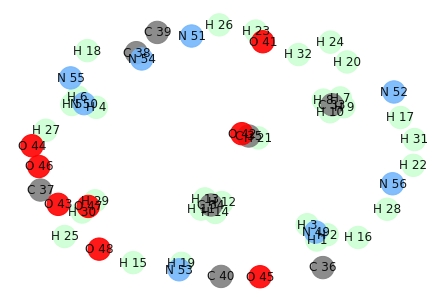

14 bonds to be formed.


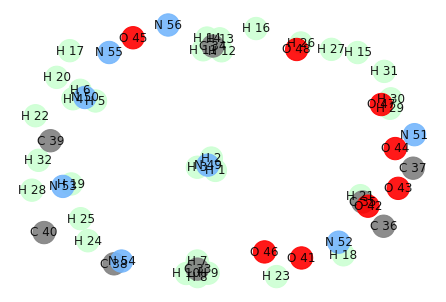

13 bonds to be formed.


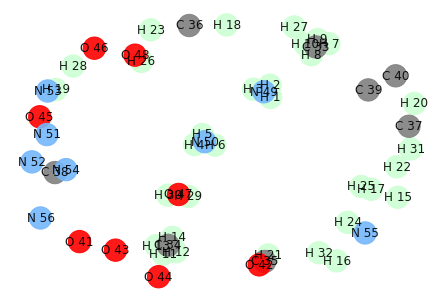

12 bonds to be formed.


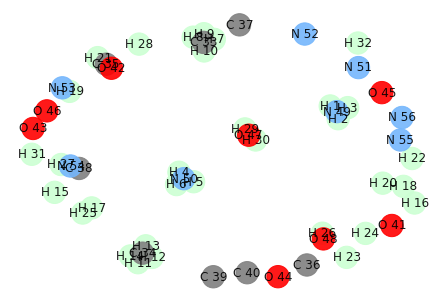

11 bonds to be formed.


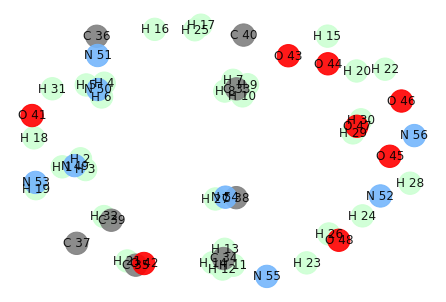

10 bonds to be formed.


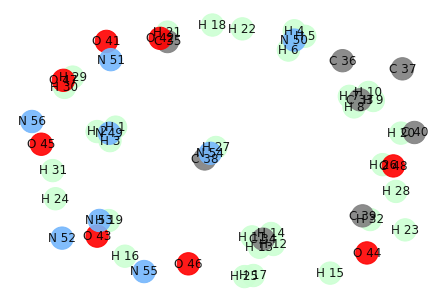

9 bonds to be formed.


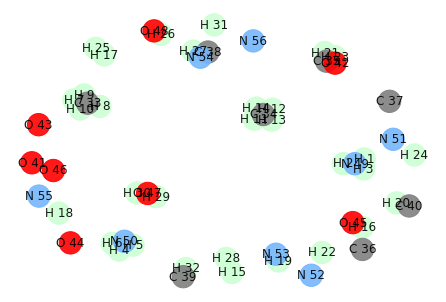

8 bonds to be formed.


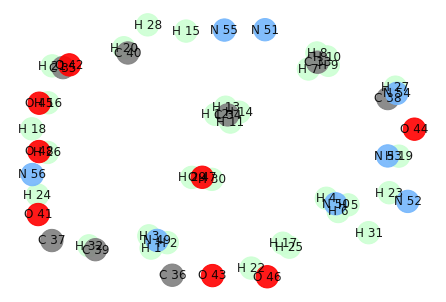

8 bonds to be formed.


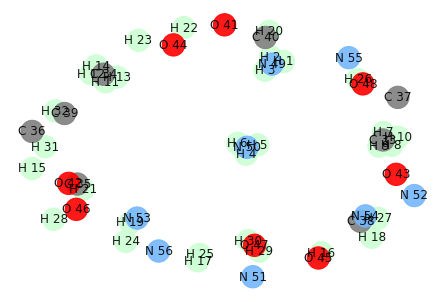

8 bonds to be formed.


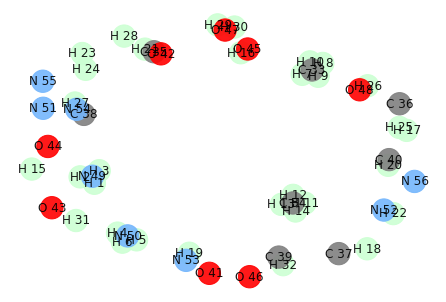

7 bonds to be formed.


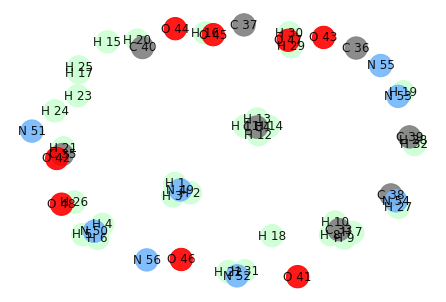

6 bonds to be formed.


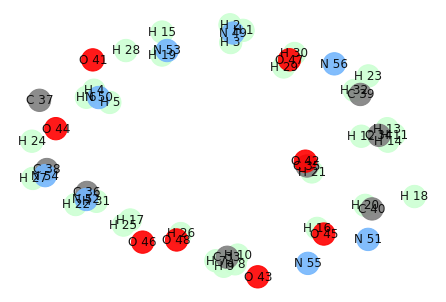

5 bonds to be formed.


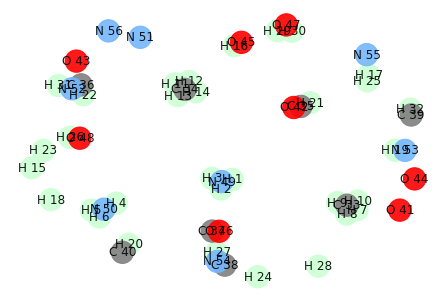

3 bonds to be formed.


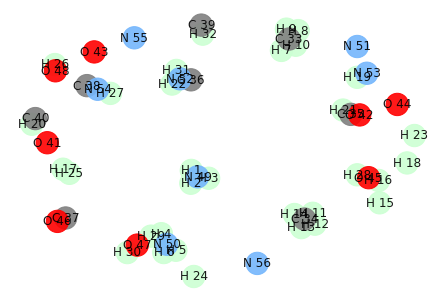

2 bonds to be formed.


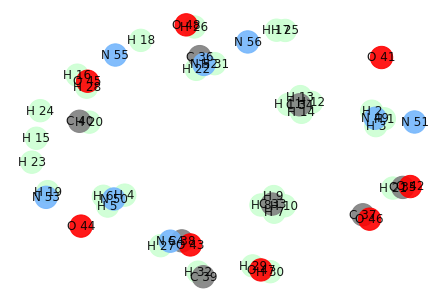

1 bonds to be formed.


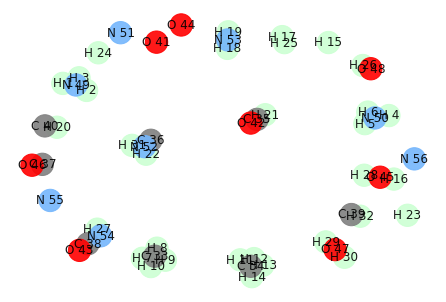

Getting the electrically neutral subgraph ...


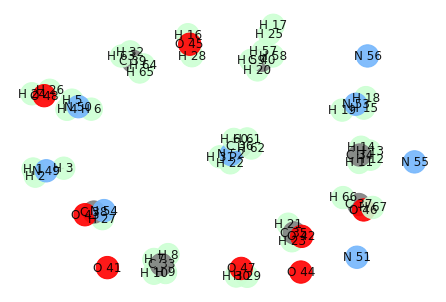

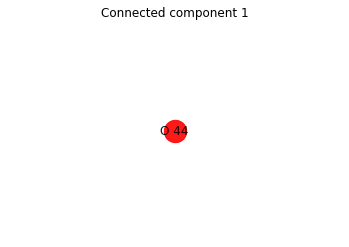

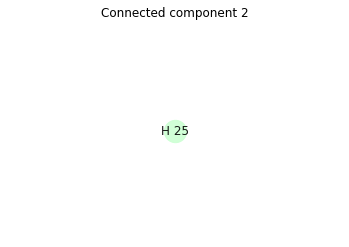

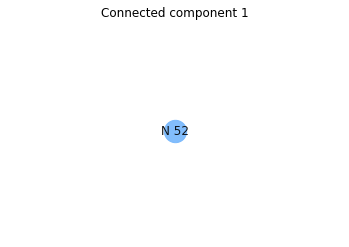

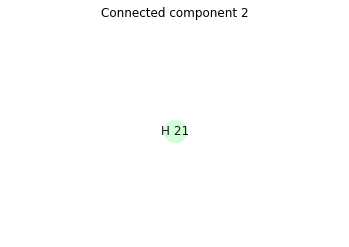

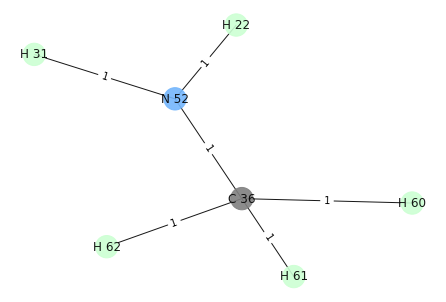

Enter G value of [H 60, C 36, N 52, H 61, H 31, H 62, H 22]: -193.3923271


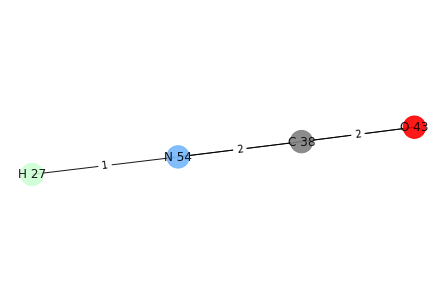

Enter G value of [H 27, O 43, C 38, N 54]: -296.6705597499796
Trail: 2
26 bonds to be formed.


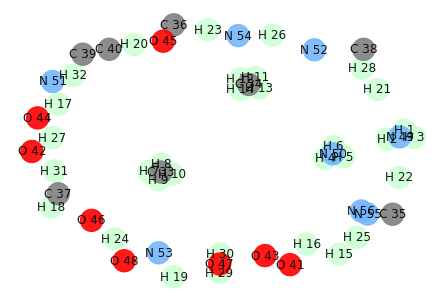

24 bonds to be formed.


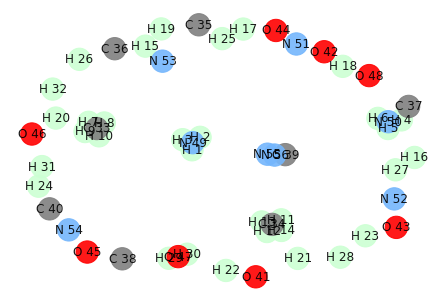

23 bonds to be formed.


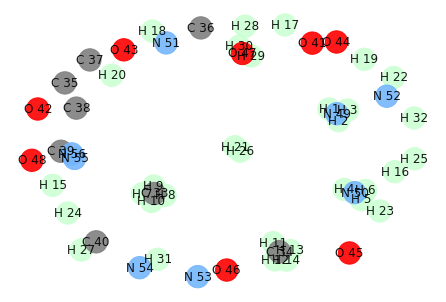

22 bonds to be formed.


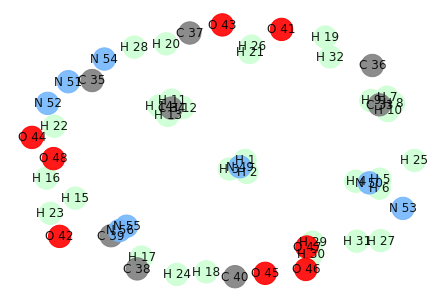

22 bonds to be formed.


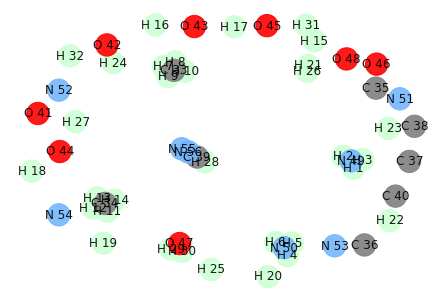

21 bonds to be formed.


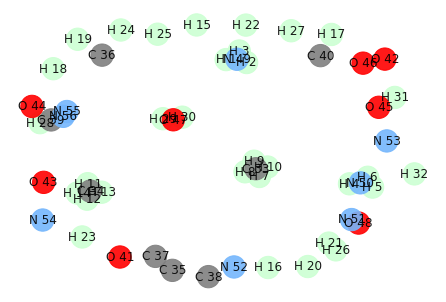

19 bonds to be formed.


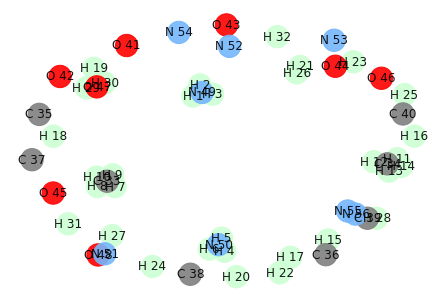

19 bonds to be formed.


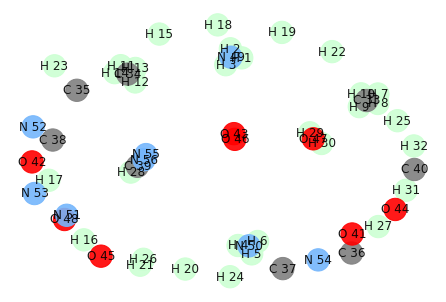

18 bonds to be formed.


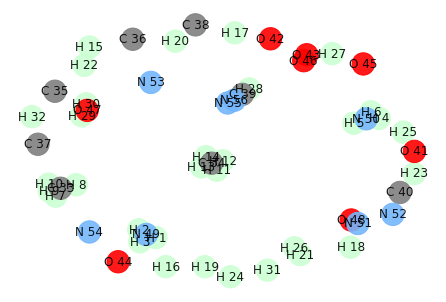

18 bonds to be formed.


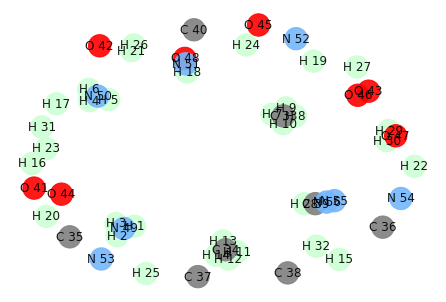

17 bonds to be formed.


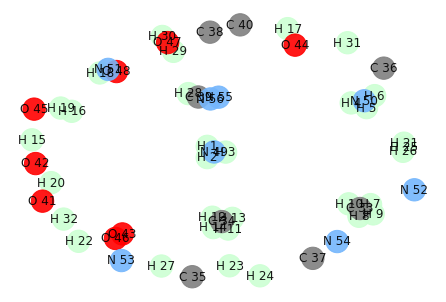

16 bonds to be formed.


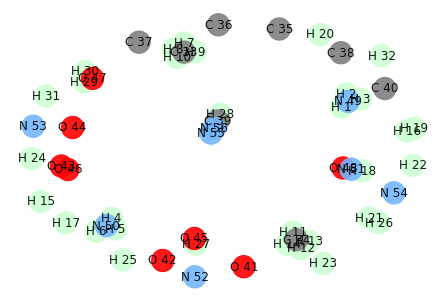

15 bonds to be formed.


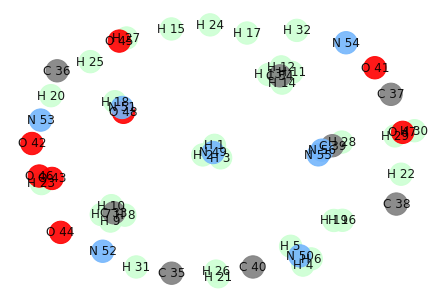

14 bonds to be formed.


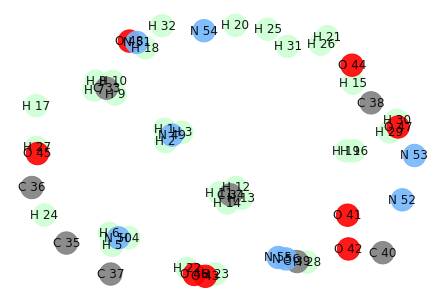

13 bonds to be formed.


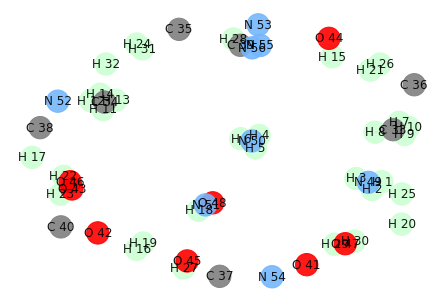

12 bonds to be formed.


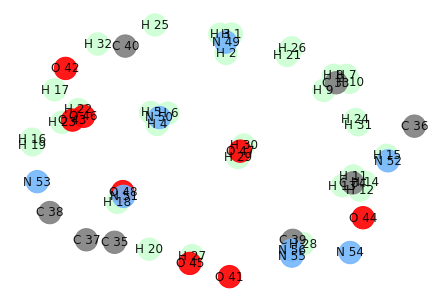

11 bonds to be formed.


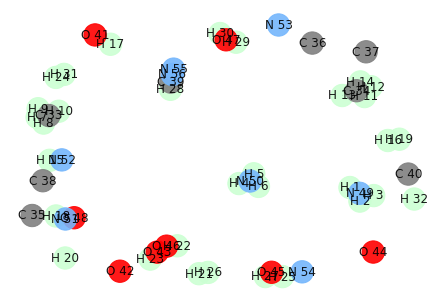

11 bonds to be formed.


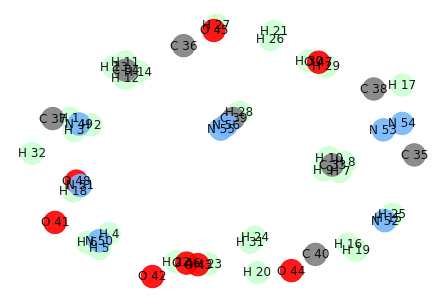

10 bonds to be formed.


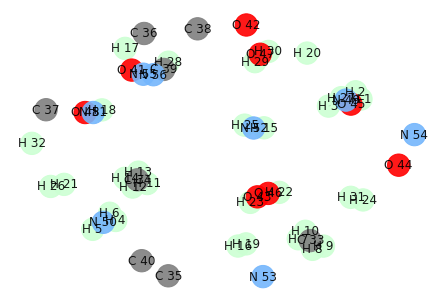

9 bonds to be formed.


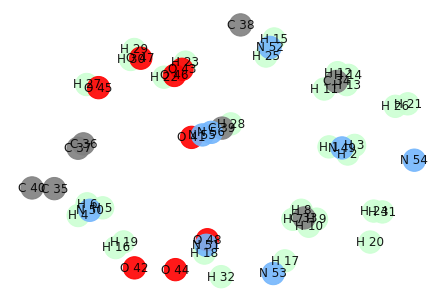

8 bonds to be formed.


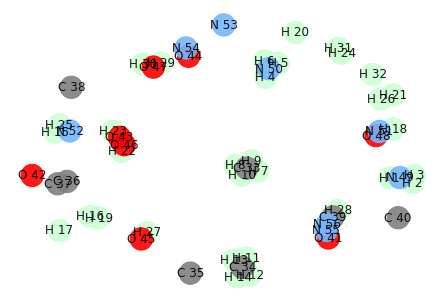

7 bonds to be formed.


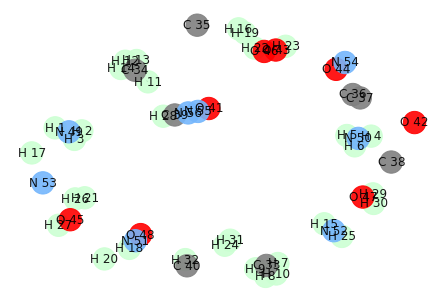

6 bonds to be formed.


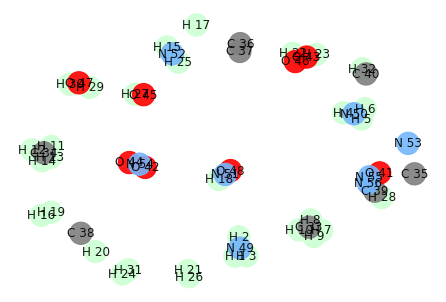

4 bonds to be formed.


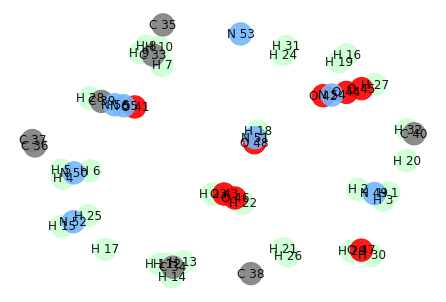

3 bonds to be formed.


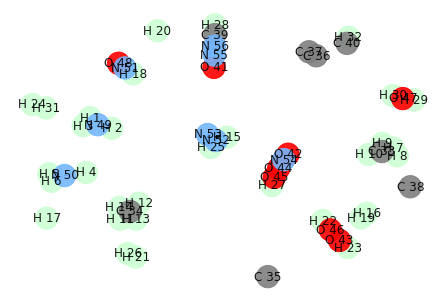

2 bonds to be formed.


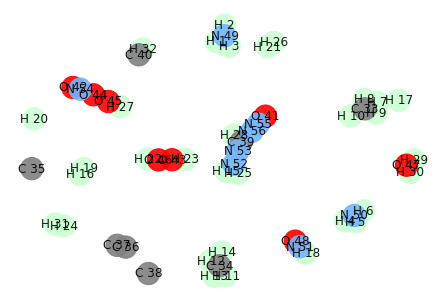

Getting the electrically neutral subgraph ...


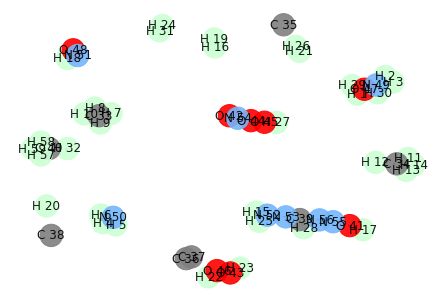

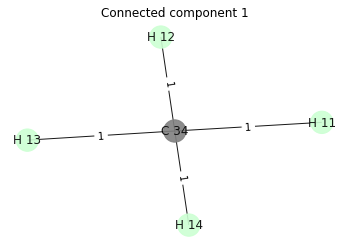

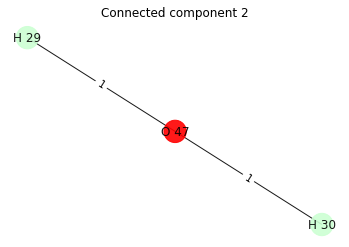

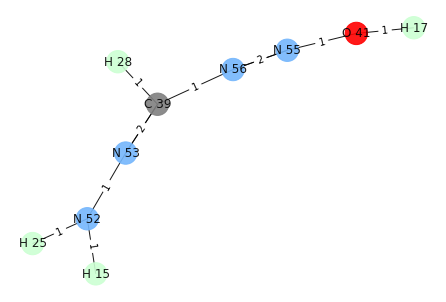

Enter G value of [H 17, H 25, H 15, N 56, N 55, H 28, N 52, N 53, O 41, C 39]: 100


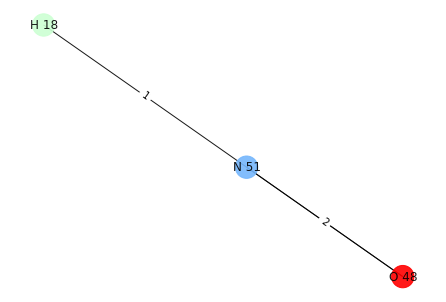

Enter G value of [N 51, H 18, O 48]: -55.40205694


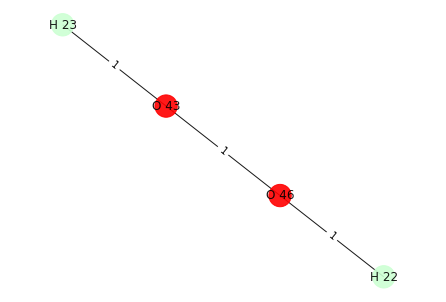

Enter G value of [O 46, H 22, O 43, H 23]: -309.1934413


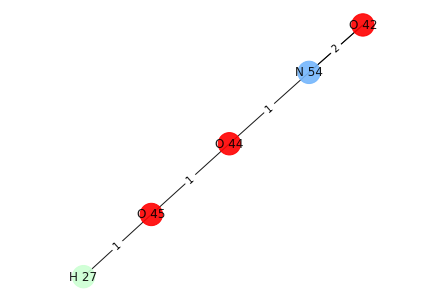

Enter G value of [O 45, H 27, O 42, N 54, O 44]: -4.536328871892925


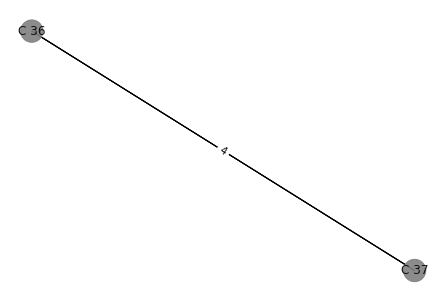

Enter G value of [C 37, C 36]: 100
Trail: 3
Getting the electrically neutral subgraph ...


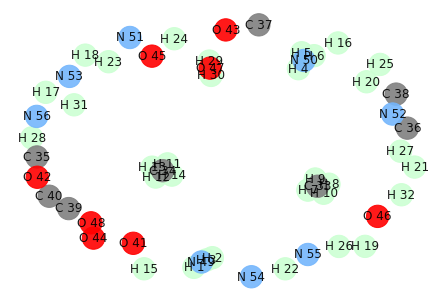

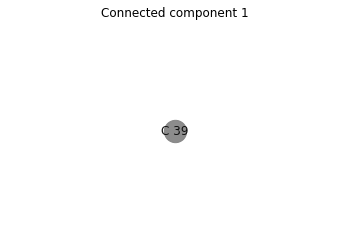

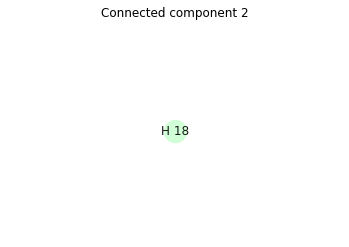

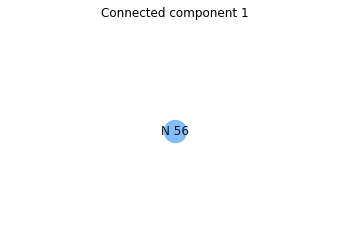

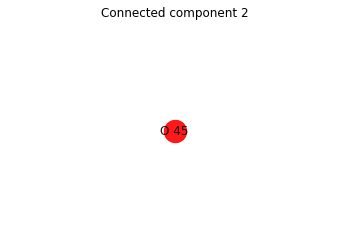

Trail: 4
Getting the electrically neutral subgraph ...


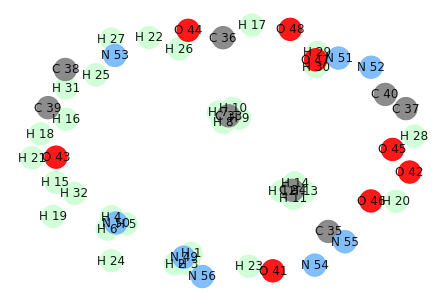

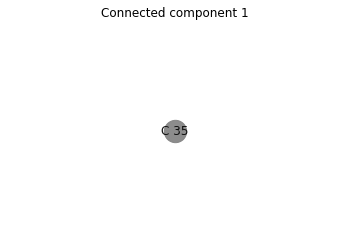

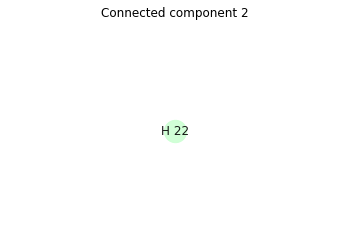

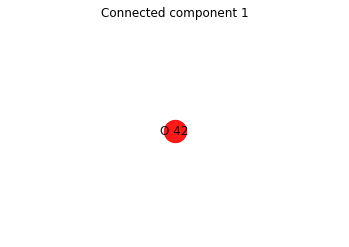

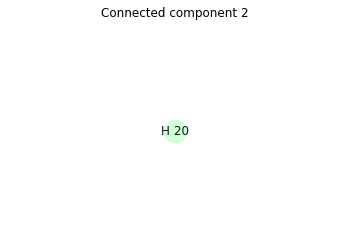

Trail: 5
Getting the electrically neutral subgraph ...


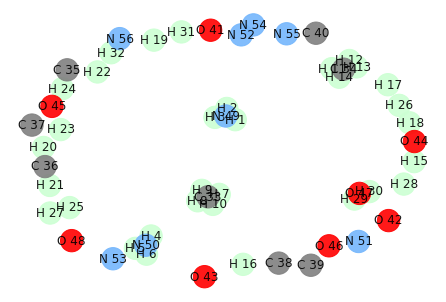

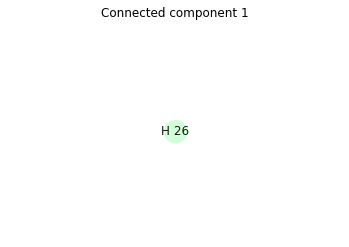

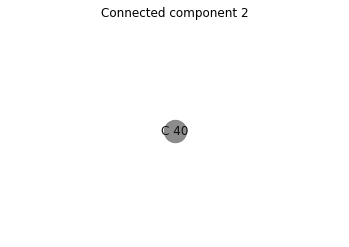

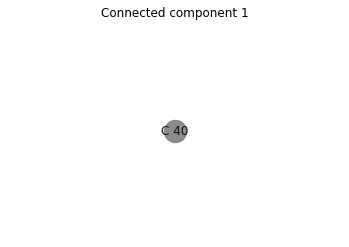

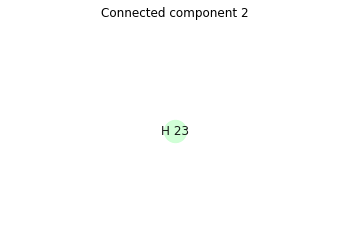

Trail: 6
Getting the electrically neutral subgraph ...


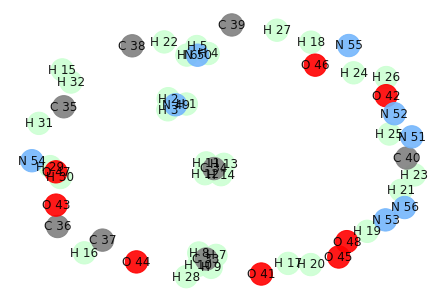

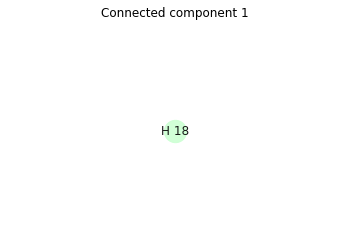

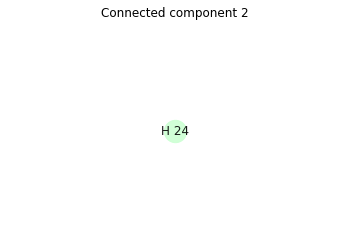

Trail: 7
Getting the electrically neutral subgraph ...


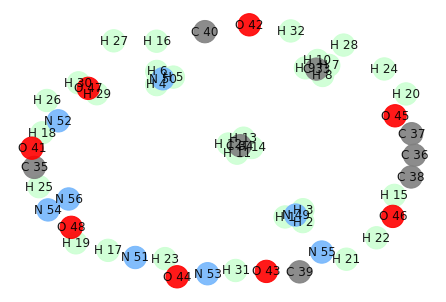

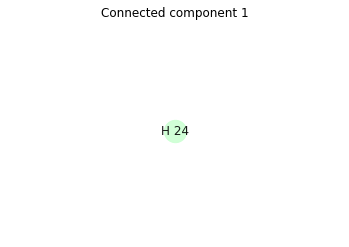

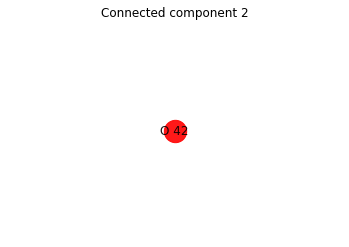

Trail: 8
Getting the electrically neutral subgraph ...


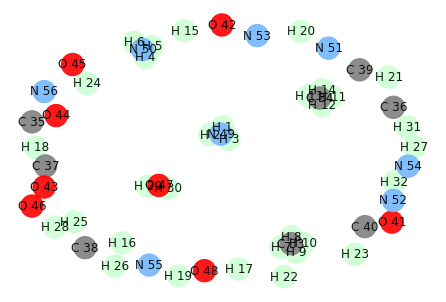

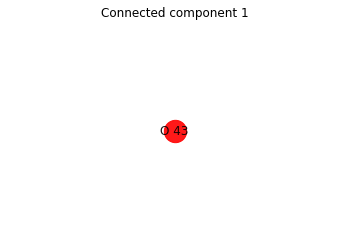

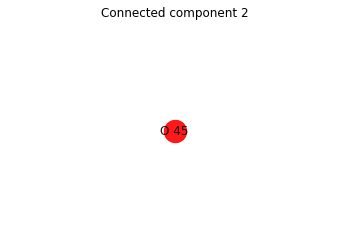

Trail: 9
Getting the electrically neutral subgraph ...


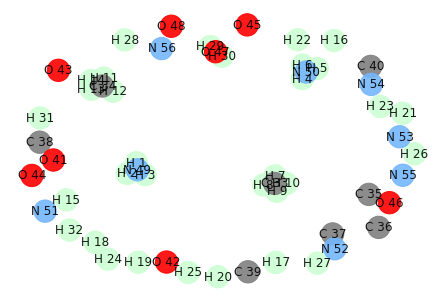

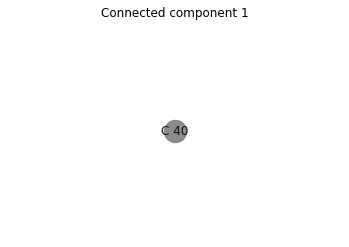

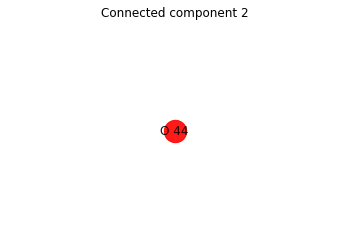

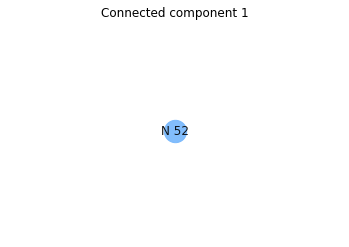

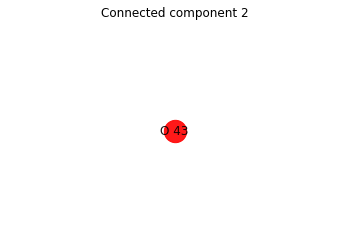

In [22]:
G_new = G.copy()
trails = 10
T = 10
max_size = 7
G_new = get_neutral_compound(G)
energy = input_G(G_new)

for i in range(trails):
    print("Trail:", i)
    G_new, energy = simulated_annealing(G_new, maximum_edges, energy, i, T, max_size)
    G_new = get_neutral_compound(G_new)
    T *= 0.995